# MFCC / speaker prediction / LSTM

In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [2]:
import sqlite3


conn = sqlite3.connect("./train-clean-100.db")
cur = conn.cursor()
cur.execute('''select distinct readerID, gender from data''' )
obj = cur.fetchall()
conn.close()
print(obj)

[(103, 1), (1034, 0), (1040, 0), (1069, 1), (1081, 0), (1088, 1), (1098, 1), (1116, 1), (118, 0), (1183, 1), (1235, 0), (1246, 1), (125, 1), (1263, 1), (1334, 0), (1355, 0), (1363, 1), (1447, 1), (1455, 0), (150, 1), (1502, 1), (1553, 1), (1578, 1), (1594, 0), (1624, 0), (163, 0), (1723, 0), (1737, 1), (1743, 0), (1841, 1), (1867, 0), (1898, 1), (19, 1), (1926, 1), (196, 0), (1963, 1), (1970, 1), (198, 1), (1992, 1), (200, 1), (2002, 0), (2007, 1), (201, 0), (2092, 1), (211, 1), (2136, 0), (2159, 0), (2182, 1), (2196, 1), (226, 1), (2289, 0), (229, 0), (233, 0), (2384, 0), (2391, 1), (2416, 1), (2436, 0), (248, 1), (250, 1), (2514, 0), (2518, 0), (254, 0), (26, 0), (2691, 1), (27, 0), (2764, 1), (2817, 1), (2836, 1), (2843, 0), (289, 1), (2893, 0), (2910, 1), (2911, 0), (2952, 0), (298, 1), (2989, 1), (302, 1), (307, 0), (311, 0), (3112, 1), (3168, 0), (32, 1), (3214, 0), (322, 1), (3235, 1), (3240, 0), (3242, 0), (3259, 1), (328, 1), (332, 0), (3374, 0), (3436, 0), (3440, 1), (3486, 0

In [3]:
import collections
collections.Counter([j for i,j in obj])


Counter({0: 126, 1: 125})

In [4]:
gender_dict = {k:v for k,v in obj}

In [5]:
def load_wav(file_path):
    from scipy.io.wavfile import read

    wavfile = file_path

    fs, data = read(wavfile)

#     print("Sampling rate :", fs)
#     print("Sample num :",len(data))
    
    return fs,data

- sampling rate = 16000 Hz
- 200,000点で，200,000/16,000  = 12.5 sec
- 50 msec くらいで切りたいので，
- 50*10^-3 * 16,000 = 800 点ずつ切ればいい？
- 2の累乗にすると1024くらい？(0.064 sec)

In [16]:
all_data = np.empty((0,1024), int)
all_labels = []
all_speakers = []

cnt = 0
for path in glob.glob("wav_samples/*"):
    fs,data = load_wav(path)
    print(cnt,path)
    
    for i in range(int(data.shape[0]/1024)):
        all_data = np.append(all_data, np.array([data[i*1024:(i+1)*1024]]), axis=0)

    label = gender_dict[int(path.split("/")[1].split("-")[0])]
    all_labels.extend([label]*int(data.shape[0]/1024))
    all_speakers.extend([cnt]*int(data.shape[0]/1024))
    
    cnt += 1
    if cnt > 80:
        break
    
print(all_data.shape)
all_labels = np.array(all_labels)

0 wav_samples/103-1240-0000.flac.wav
1 wav_samples/1034-121119-0000.flac.wav
2 wav_samples/1040-133433-0000.flac.wav
3 wav_samples/1069-133699-0000.flac.wav
4 wav_samples/1081-125237-0000.flac.wav
5 wav_samples/1088-129236-0000.flac.wav
6 wav_samples/1098-133695-0000.flac.wav
7 wav_samples/1116-132847-0000.flac.wav
8 wav_samples/118-121721-0000.flac.wav
9 wav_samples/1183-124566-0000.flac.wav
10 wav_samples/1235-135883-0000.flac.wav
11 wav_samples/1246-124548-0000.flac.wav
12 wav_samples/125-121124-0000.flac.wav
13 wav_samples/1263-138246-0000.flac.wav
14 wav_samples/1334-135589-0000.flac.wav
15 wav_samples/1355-39947-0000.flac.wav
16 wav_samples/1363-135842-0000.flac.wav
17 wav_samples/1447-130550-0000.flac.wav
18 wav_samples/1455-134435-0000.flac.wav
19 wav_samples/150-126107-0000.flac.wav
20 wav_samples/1502-122615-0000.flac.wav
21 wav_samples/1553-140047-0000.flac.wav
22 wav_samples/1578-140045-0000.flac.wav
23 wav_samples/1594-135914-0000.flac.wav
24 wav_samples/1624-142933-0000.f

In [17]:
all_data.shape

(15561, 1024)

In [23]:
all_speakers[-1]

80

In [18]:
x_train = all_data[:15000]
y_train = all_labels[:15000]
x_test = all_data[15000:]
y_test = all_labels[15000:]

In [24]:
import librosa

# mfccs = librosa.feature.mfcc(x_train[0], sr=16000, hop_length=2048)

X_train = np.array([librosa.feature.mfcc(x, sr=16000, hop_length=2048) for x in x_train])
X_test = np.array([librosa.feature.mfcc(x,  sr=16000, hop_length=2048) for x in x_test])

In [25]:
X_train = X_train.reshape(-1,20)
X_test = X_test.reshape(-1,20)

In [26]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.layers import Activation
from keras.layers import LSTM

Using TensorFlow backend.


In [27]:
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)

In [29]:
num_classes = 2
batch_size = 64
epochs = 200

# LSTM model
model = Sequential()
model.inputs
model.add(LSTM(10, batch_input_shape=(1,20,1), stateful=True))
model.add(Dense(2))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

# フィッティング(学習)
# history = model.fit(X_train, Y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=(X_test, Y_test))

# # スコア計算・表示
# score = model.evaluate(X_test, Y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (1, 10)                   480       
_________________________________________________________________
dense_1 (Dense)              (1, 2)                    22        
_________________________________________________________________
activation_1 (Activation)    (1, 2)                    0         
Total params: 502
Trainable params: 502
Non-trainable params: 0
_________________________________________________________________


In [32]:
print('Train...')
for epoch in range(1):
    mean_tr_acc = []
    mean_tr_loss = []
    
    for i in range(len(X_train)):
        if i%1000 == 0:
            print(i)    
        
        Y_true = Y_train[i]
        s_true = all_speakers[i]
        
        batch_sec_len = len(X_train[i])        
        
        tr_loss, tr_acc = model.train_on_batch(X_train[i].reshape(1,20,1), np.array([Y_true]))

        mean_tr_acc.append(tr_acc)
        mean_tr_loss.append(tr_loss)
        
        if s_true != 80:
            if s_true != all_speakers[i+1]:
                model.reset_states()

    print('accuracy training = {}'.format(np.mean(mean_tr_acc)))
    print('loss training = {}'.format(np.mean(mean_tr_loss)))
    print('___________________________________')


Train...
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
accuracy training = 0.5823333263397217
loss training = 6.712549686431885
___________________________________


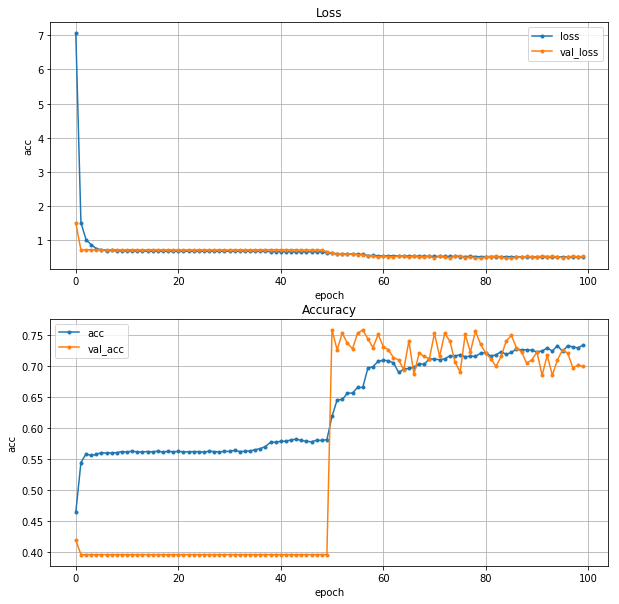

In [94]:
import matplotlib.pyplot as plt
# plot results
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Loss')
epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')

plt.subplot(2,1,2)
plt.title('Accuracy')
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

# plt.savefig('rms_cifar3_50epochs.png')